# Lotka-Volterra inference tests

In [7]:
import numpy as np
import corner
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

In [8]:
def load_metrics(simulator='lotkavolterra',
                 method='maf',
                 label='',
                 reference_method='maf',
                 train_rather_than_test=False,
                 reference_label='',
                 single_theta=True,
                 n_runs=5):
    
    reference_path = '../../data/results/' + simulator + '/' + reference_method + '/'
    path = '../../data/results/' + simulator + '/' + method + '/'
    theta_label = '_singletheta' if single_theta else ''
    test_train_label = 'train' if train_rather_than_test else 'test'
    
    # Reference likelihood
    log_p_references = []
    t_references = []
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p_references.append(np.load(reference_path + 'log_p_hat_' + test_train_label + theta_label + reference_label + run_label + '.npy'))
            t_references.append(np.load(reference_path + 't_hat_' + test_train_label + theta_label + reference_label + run_label + '.npy'))
        except FileNotFoundError as e:
            # print(e)
            pass
    log_p_references = np.array(log_p_references)
    log_p_reference = np.median(log_p_references, axis=0)
    t_references = np.array(t_references)
    t_reference = np.median(t_references, axis=0)
    
    # Calculate metrics
    expected_log_ps = []
    roc_aucs = []
    mses = []
    score_mses = []
    
    for run in range(n_runs):
        run_label = '' if run == 0 else '_run' +  str(run)
        try:
            log_p = np.load(
                path + 'log_p_hat_' + test_train_label + theta_label + label + run_label + '.npy'
            )
            log_p[~np.isfinite(log_p)] = -100.
            
            t = np.load(
                path + 't_hat_' + test_train_label + theta_label + label + run_label + '.npy'
            )
            t[~np.isfinite(t)] = -100.
            
            expected_log_ps.append(
                1. / log_p.shape[0] * np.sum(log_p)
            )
            mses.append(
                mean_squared_error(log_p_reference, log_p)
            )
            score_mses.append(
                mean_squared_error(t_reference, t)
            )
            roc_aucs.append(
                np.load(path + 'roc_auc_surrogate_vs_simulator' + label + run_label + '.npy')[0]
            )
        
        except FileNotFoundError as e:
            # print(e)
            pass
        
    expected_log_ps = np.array(expected_log_ps)
    roc_aucs = np.array(roc_aucs)
    mses = np.array(mses)
    score_mses = np.array(score_mses)
        
    # Calculate mean and std
    expected_log_p_mean = np.mean(expected_log_ps)
    expected_log_p_uncertainty = np.std(expected_log_ps) / len(expected_log_ps)**0.5
    
    mse_mean = np.mean(mses)
    mse_uncertainty = np.std(mses) / len(mses)**0.5
    
    score_mse_mean = np.mean(score_mses)
    score_mse_uncertainty = np.std(score_mses) / len(score_mses)**0.5
    
    roc_auc_mean = np.mean(roc_aucs)
    roc_auc_uncertainty = np.std(roc_aucs) / len(roc_aucs)**0.5
    
    if len(roc_aucs) == 0:
        roc_auc_mean = np.nan
        roc_auc_uncertainty = np.nan
    
    return (expected_log_p_mean, expected_log_p_uncertainty,
            mse_mean, mse_uncertainty,
            score_mse_mean, score_mse_uncertainty,
            roc_auc_mean, roc_auc_uncertainty)


## Metrics as function of method and sample size

In [9]:
sample_sizes = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

methods = ['maf', 'scandal']
filenames = ['', '']
method_labels = ['MAF', 'SCANDAL']


In [10]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label= filename + samplesize_label,
                reference_method='maf',
                reference_label='_trainingsamplesize_200000',
                single_theta=False
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_mean = metrics[:,:,0]
expected_log_p_uncertainty = metrics[:,:,1]
mse_mean = metrics[:,:,2]
mse_uncertainty = metrics[:,:,3]
score_mse_mean = metrics[:,:,4]
score_mse_uncertainty = metrics[:,:,5]
roc_auc_mean = metrics[:,:,6]
roc_auc_uncertainty = metrics[:,:,7]


In [11]:
metrics = []

for method, filename in zip(methods[:], filenames[:]):
    metrics_this_method = []
    
    for sample_size in sample_sizes:
        
        samplesize_label = '_trainingsamplesize_' + str(sample_size)
            
        metrics_this_method.append(
            load_metrics(
                method=method,
                label= filename + samplesize_label,
                reference_method='maf',
                reference_label='_trainingsamplesize_200000',
                single_theta=True
            )
        )
        
    metrics.append(metrics_this_method)
    
metrics = np.array(metrics)

expected_log_p_st_mean = metrics[:,:,0]
expected_log_p_st_uncertainty = metrics[:,:,1]
mse_st_mean = metrics[:,:,2]
mse_st_uncertainty = metrics[:,:,3]
score_mse_st_mean = metrics[:,:,4]
score_mse_st_uncertainty = metrics[:,:,5]
roc_auc_mean = metrics[:,:,6]
roc_auc_uncertainty = metrics[:,:,7]


## Plot

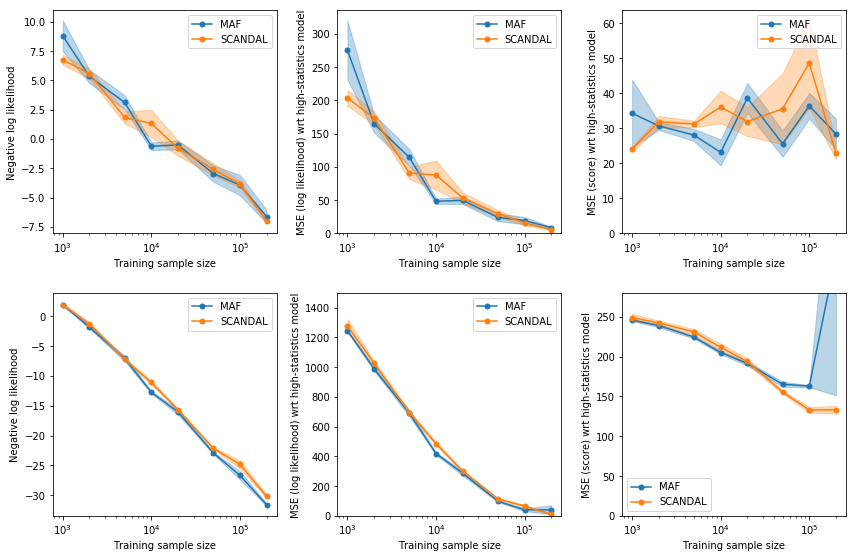

In [12]:
colors = ['C' + str(i) for i in range(10)]

fig = plt.figure(figsize=(12,8))



ax = plt.subplot(2,3,1)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_st_mean[m] - expected_log_p_st_uncertainty[m],
        - expected_log_p_st_mean[m] + expected_log_p_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,2)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_st_mean[m] - mse_st_uncertainty[m],
        mse_st_mean[m] + mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)



ax = plt.subplot(2,3,3)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_st_mean[m] - score_mse_st_uncertainty[m],
        score_mse_st_mean[m] + score_mse_st_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_st_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,None)



ax = plt.subplot(2,3,4)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        - expected_log_p_mean[m] - expected_log_p_uncertainty[m],
        - expected_log_p_mean[m] + expected_log_p_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        - expected_log_p_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('Negative log likelihood')
ax.set_xscale("log", nonposx='clip')
#plt.ylim(-20.,200.)



ax = plt.subplot(2,3,5)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        mse_mean[m] - mse_uncertainty[m],
        mse_mean[m] + mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (log likelihood) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,1500.)



ax = plt.subplot(2,3,6)

for m, method in enumerate(method_labels):
    plt.fill_between(
        sample_sizes,
        score_mse_mean[m] - score_mse_uncertainty[m],
        score_mse_mean[m] + score_mse_uncertainty[m],
        color=colors[m],
        alpha=0.3
    )
    
for m, method in enumerate(method_labels):
    plt.plot(
        sample_sizes,
        score_mse_mean[m],
        color=colors[m],
        lw=1.5,
        ls='-',
        marker='o',
        ms=5.,
        label=method
    )
    
plt.legend()

plt.xlabel('Training sample size')
plt.ylabel('MSE (score) wrt high-statistics model')
ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')
plt.ylim(0.,280.)
    
    

plt.tight_layout()
plt.show()


## Original vs simulated samples

In [13]:
x_ranges = [(-3.,3.) for _ in range(9)]
x_bins = [50 for _ in range(9)]

x_simulator = np.load('../../data/samples/lotkavolterra/x_test_focus_singletheta.npy')
x_maf = np.load('../../data/results/lotkavolterra/maf/samples_from_p_hat_trainingsamplesize_200000.npy')

In [ ]:
range_ = -3., 3.
bins = 20

plt.figure(figsize=(12,12))

for i in range(9):
    ax = plt.subplot(3,3,i+1)
    
    plt.hist(x_simulator, histtype='step', range=range_, bins=bins)    
    plt.hist(x_maf, histtype='step', range=range_, bins=bins)
    
    

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/corner/corner.py:532: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/corner/corner.py:536: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]


KeyboardInterrupt: 

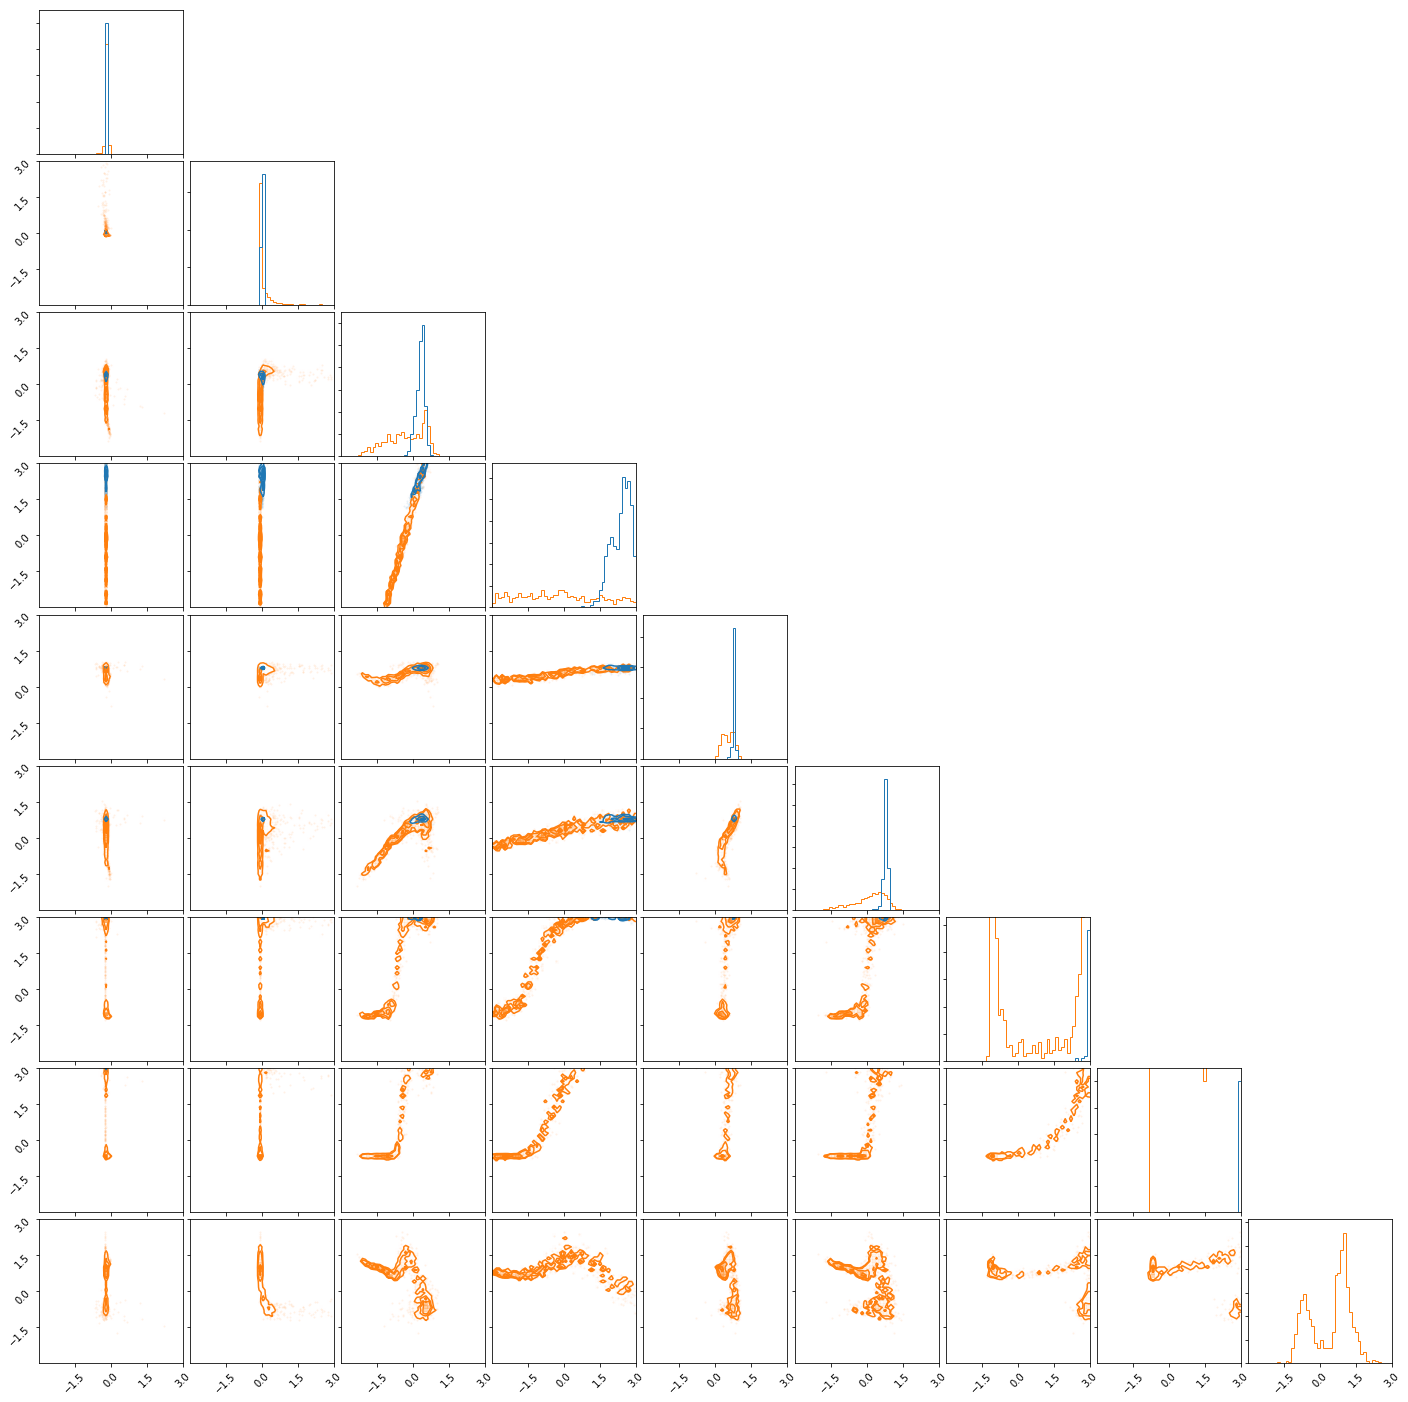

In [14]:
fig = corner.corner(x_maf[::100],
                   #labels=x_labels,
                   range=x_ranges,
                   bins=x_bins,
                   color='C1', alpha=0.5)
_ = corner.corner(x_simulator[::100],
                   fig=fig,
                   #labels=x_labels,
                   range=x_ranges,
                   bins=x_bins,
                   color='C0', alpha=0.5)